In [1]:
import pandas as pd
import numpy as np
import itertools as it
import os
import io
import logging

import boto3
import sys
import json
import snowflake.connector

# Reading Data 

In [2]:
input_bucket = "hbo-ingest-datascience-content-dev"

In [3]:
logger = logging.getLogger()
logger.info(f'Loading inputs')
data_list =[]

s3 = boto3.resource('s3')
bucket = s3.Bucket(input_bucket)

for obj in bucket.objects.filter(Prefix='cost_allocation/dev/churn_metric_0906'): #churn_metric_0811
            key = obj.key
            logger.info('Loading csv file {}'.format(key))
            body = obj.get()['Body']
            print('Reading {0} features'.format(key))
            churn_metric = pd.read_csv(body, na_values = [r'\\\\N'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


Reading cost_allocation/dev/churn_metric_0906.csv features


In [4]:
churn_metric.head()

,Unnamed: 0,genre,medal,category,churn_per_hr_person
0,0,action,Platinum,movies,-0.028358
1,1,action,Gold,series,-0.020530
2,2,action,Gold,movies,-0.027117
3,3,action,Silver,series,-0.005406
4,4,action,Silver,movies,-0.019190


In [89]:
hours_viewed = pd.read_csv('content_slate_prediction.csv')

In [90]:
hours_viewed = hours_viewed[['title_name', 'season_number', 'offering_start_date', 'prediction', 'Genre', 
                             'medal', 'content_category', 'asset_run_time_hours']]

In [91]:
hours_viewed.rename(columns = {'Genre': 'genre', 'content_category':'category'}, inplace = True)

In [92]:
hours_viewed.category.unique()

array(['Docuseries', 'Special / Stand-Up', 'Documentary',
       'Scripted Series - Live Action Drama', 'Sports - Talk',
       'Scripted Limited Series - Live Action Drama', 'News / Talk',
       'Scripted Series - Live Action Comedy',
       'Sports - Special / Limited Series / Doc',
       'Scripted - Movie - Drama / Romance',
       'Unscripted Series - Docufollow / Reality',
       'Kids - Animated Series',
       'Scripted - Movie - Comedy / Rom Com / Holiday',
       'Scripted Series - Animated Comedy',
       'Unscripted Series - Format / Competition',
       'Kids - Scripted Series', 'Pay 1 - Studio', 'Pay 1 - Indie'],
      dtype=object)

In [93]:
churn_metric.category.unique()

array(['movies', 'series'], dtype=object)

In [94]:
hours_viewed.loc[hours_viewed['genre'] == 'Comedy', 'genre'] = 'comedy'
hours_viewed.loc[hours_viewed['genre'] == 'Drama', 'genre'] = 'drama'
hours_viewed.loc[(hours_viewed['category'].str.contains('Action')) &(hours_viewed['genre']!='drama'), 
                 'genre'] = 'action'
hours_viewed.loc[~hours_viewed['genre'].isin(['action', 'comedy', 'drama']), 'genre'] = 'other'

hours_viewed.loc[hours_viewed['medal'] == 'None', 'medal'] = 'Bronze'

hours_viewed.loc[hours_viewed['category'].str.contains('Series|series'), 'category'] = 'series'
hours_viewed.loc[hours_viewed['category']!='series', 'category'] = 'movies'

In [97]:
hours_viewed = hours_viewed.merge(churn_metric[['genre','medal','category', 'churn_per_hr_person']], on = ['genre','medal','category'])

In [99]:
hours_viewed['change_in_churn_60d_prediction'] = hours_viewed['prediction'] * hours_viewed['churn_per_hr_person']

In [100]:
hours_viewed_thresh = hours_viewed

# Allocate the 60-Day Churn to monthly

In [122]:
ever_green_titles = pd.read_csv('final_evergreen_title_list.csv') #final_evergreen_title_list.csv # ever_green_titles.csv

In [123]:
len(ever_green_titles.title_id.unique())

11

In [103]:
ever_green_title_name = ever_green_titles.title_name.unique()
norm_title_name = hours_viewed_thresh[~hours_viewed_thresh['title_name'].isin(ever_green_title_id)].title_name.unique()

In [104]:
ever_green_title_name

array(['The Sopranos', 'Curb Your Enthusiasm', 'Sex and the City',
       'Game of Thrones', 'American Pie', 'War Dogs',
       'Pretty Little Liars', 'The Big Bang Theory', 'Friends',
       'Annabelle Comes Home', 'X-Men: Dark Phoenix'], dtype=object)

### 1. Normal Titles

In [126]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [127]:
from scipy.optimize import curve_fit

In [128]:
historical_weekly_hours_viewed = pd.read_csv('historical_weekly_hours_viewed.csv')

In [129]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

## 90% of the retention value deteriorates in the first year
x = historical_weekly_hours_viewed['days_on_hbo_max']
y = historical_weekly_hours_viewed['target']

popt, pcov = curve_fit(func, x, y)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [130]:
func(0, *popt)

9.668299515987423

In [131]:
popt #0.00059137, 0.03019112, 0.00055421

array([9.10159297, 0.0671376 , 0.56670655])

In [132]:
x1 = pd.Series(np.arange(0,365,1))
y1 = func(x1, *popt)

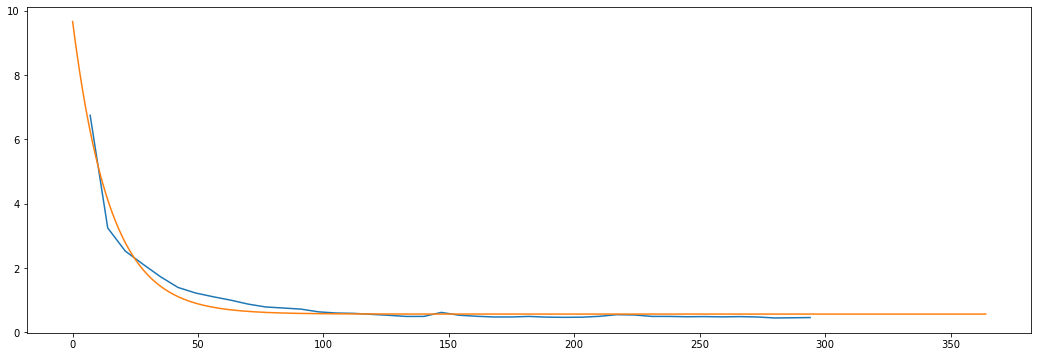

In [133]:
fig, ax = plt.subplots(figsize=(18, 6))
plt.plot(x, y)
plt.plot(x1, y1)
plt.show()

In [145]:
dt_df = pd.DataFrame()
dt_df['days_on_hbo_max'] = [i for i in range(0, 365*1, 1)]
dt_df['factor'] = func(dt_df['days_on_hbo_max'], *popt)
dt_df['key'] = 1

In [146]:
day_60_cum_sum = dt_df[dt_df['days_on_hbo_max']<60].factor.sum()

In [147]:
hours_viewed_decay_norm = hours_viewed_thresh
hours_viewed_decay_norm['key'] = 1

hours_viewed_decay_norm = hours_viewed_decay_norm.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

hours_viewed_decay_norm['change_in_churn_prediction'] = hours_viewed_decay_norm['change_in_churn_60d_prediction']/day_60_cum_sum*hours_viewed_decay_norm['factor']*hours_viewed_decay_norm['asset_run_time_hours']

hours_viewed_decay_norm['request_date'] = pd.to_datetime(hours_viewed_decay_norm['offering_start_date']) \
                                        + pd.to_timedelta(hours_viewed_decay_norm['days_on_hbo_max'], unit='D')

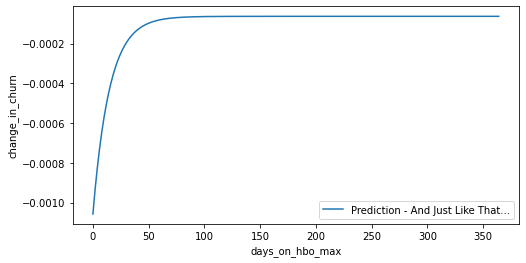

In [148]:
fig, ax = plt.subplots(figsize=(8, 4))
test = hours_viewed_decay_norm
plot_df = test[test['title_name'].str.contains('EUPHORIA S3')]
plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn_prediction'], label='Prediction - And Just Like That...')

ax.set_xlabel('days_on_hbo_max')
ax.set_ylabel('change_in_churn')
ax.legend()

plt.show()

### 2. Evergreen Titles

#### 2.2 Keep the retention value all the way along

In [151]:
# dt_df = pd.DataFrame()
# dt_df['days_on_hbo_max'] = [i for i in range(0, 365*3, 1)]
# dt_df['key'] = 1

# hours_viewed_decay_evergreen = hours_viewed_thresh[hours_viewed_thresh['title_id'].isin(ever_green_title_id)]
# hours_viewed_decay_evergreen['key'] = 1

# hours_viewed_decay_evergreen = hours_viewed_decay_evergreen.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

# hours_viewed_decay_evergreen['change_in_churn'] = hours_viewed_decay_evergreen['change_in_churn_60d']/60*hours_viewed_decay_evergreen['asset_run_time_hours']
# hours_viewed_decay_evergreen['change_in_churn_prediction'] = hours_viewed_decay_evergreen['change_in_churn_60d_prediction']/60*hours_viewed_decay_evergreen['asset_run_time_hours']

# hours_viewed_decay_evergreen['request_date'] = pd.to_datetime(hours_viewed_decay_evergreen['offering_start_date']) \
#                                         + pd.to_timedelta(hours_viewed_decay_evergreen['days_on_hbo_max'], unit='D')

# hours_viewed_decay_evergreen = hours_viewed_decay_evergreen[hours_viewed_decay_evergreen['request_date'] <= '2023-03-01']


In [152]:
# fig, ax = plt.subplots(figsize=(8, 4))
# test = hours_viewed_decay_evergreen


# for i in range(1,2,1):
#     plot_df = test[(test['title_name'] == 'Friends') &(test['season_number'] == i)]
#     plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label= 'Actual - Friends S' + str(i))
#     plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn_prediction'], label= 'Prediction - Friends S' + str(i))

# ax.set_xlabel('days_on_hbo_max')
# ax.set_ylabel('change_in_churn')
# ax.legend()

# plt.show()

## UNION ALL THE DFs

In [153]:
# data = pd.concat([hours_viewed_decay_norm[['title_name', 'title_id', 'season_number', 'request_date',  'days_on_hbo_max', 'change_in_churn', 'change_in_churn_prediction']],
#                 hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'request_date',  'days_on_hbo_max', 'change_in_churn', 'change_in_churn_prediction']] ],
#                 axis = 0)
data = hours_viewed_decay_norm

In [154]:
data['date_month'] = data['request_date'].dt.to_period('M')

In [155]:
data.head()

,title_name,season_number,offering_start_date,prediction,genre,medal,category,asset_run_time_hours,churn_per_hr_person,change_in_churn_60d_prediction,days_on_hbo_max,factor,change_in_churn_prediction,request_date,date_month
0,RAMY YOUSSEF SPECIAL,NaN,2023-11-01,0.03309,other,Gold,movies,1.0,-0.042203,-0.001397,0,9.668300,-0.000079,2023-11-01,2023-11
1,RAMY YOUSSEF SPECIAL,NaN,2023-11-01,0.03309,other,Gold,movies,1.0,-0.042203,-0.001397,1,9.077301,-0.000074,2023-11-02,2023-11
2,RAMY YOUSSEF SPECIAL,NaN,2023-11-01,0.03309,other,Gold,movies,1.0,-0.042203,-0.001397,2,8.524679,-0.000069,2023-11-03,2023-11
3,RAMY YOUSSEF SPECIAL,NaN,2023-11-01,0.03309,other,Gold,movies,1.0,-0.042203,-0.001397,3,8.007940,-0.000065,2023-11-04,2023-11
4,RAMY YOUSSEF SPECIAL,NaN,2023-11-01,0.03309,other,Gold,movies,1.0,-0.042203,-0.001397,4,7.524755,-0.000061,2023-11-05,2023-11


#### Write to S3/SF

In [156]:
import boto3
import io

def to_s3(filename, output_bucket, content):
    client = boto3.client('s3')
    client.put_object(Bucket=output_bucket, Key=filename, Body=content)
    
output_bucket = 'hbo-outbound-datascience-content-dev'
s3 = boto3.resource('s3')
bucket = s3.Bucket(output_bucket)

def write_to_sf(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'title_hours_viewed_retention/{}.csv'.format(file_name)
    to_s3(filename, output_bucket, content)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [157]:
data.head()

,title_name,season_number,offering_start_date,prediction,genre,medal,category,asset_run_time_hours,churn_per_hr_person,change_in_churn_60d_prediction,days_on_hbo_max,factor,change_in_churn_prediction,request_date,date_month
0,RAMY YOUSSEF SPECIAL,NaN,2023-11-01,0.03309,other,Gold,movies,1.0,-0.042203,-0.001397,0,9.668300,-0.000079,2023-11-01,2023-11
1,RAMY YOUSSEF SPECIAL,NaN,2023-11-01,0.03309,other,Gold,movies,1.0,-0.042203,-0.001397,1,9.077301,-0.000074,2023-11-02,2023-11
2,RAMY YOUSSEF SPECIAL,NaN,2023-11-01,0.03309,other,Gold,movies,1.0,-0.042203,-0.001397,2,8.524679,-0.000069,2023-11-03,2023-11
3,RAMY YOUSSEF SPECIAL,NaN,2023-11-01,0.03309,other,Gold,movies,1.0,-0.042203,-0.001397,3,8.007940,-0.000065,2023-11-04,2023-11
4,RAMY YOUSSEF SPECIAL,NaN,2023-11-01,0.03309,other,Gold,movies,1.0,-0.042203,-0.001397,4,7.524755,-0.000061,2023-11-05,2023-11


In [ ]:
pivot_table = pd.pivot_table(data, values='D', index=['A', 'B'],
                           columns=['C'], aggfunc="sum", fill_value=0)

In [137]:
# data.to_csv('daily_monthly_retention_value.csv')

In [158]:
filename = 'content_slate_daily_monthly_retention_value_'+pd.Timestamp.today().strftime('%Y-%m-%d') 

In [159]:
write_to_sf(data,  filename)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [160]:
output_bucket+'/title_hours_viewed_retention/{}.csv'.format(filename)

'hbo-outbound-datascience-content-dev/title_hours_viewed_retention/content_slate_daily_monthly_retention_value_2023-09-20.csv'

In [141]:
data[data['date_month'] == '2023-01'].groupby(['title_name', 'title_id', 'season_number', 'offering_start_date']).mean().reset_index()\
.sort_values(by = ['change_in_churn']).to_csv('2023-01_rank.csv')